In [67]:
# if postman_problems package is installed
from postman_problems.solver import cpp
from postman_problems.stats import calculate_postman_solution_stats

# find CPP solution
circuit, graph = cpp(edgelist_filename='edgelist_seven_bridges.csv', start_node='D')

# print solution route
for e in circuit:
    print(e)

# print solution summary stats
for k, v in calculate_postman_solution_stats(circuit).items():
    print(k, v)

('D', 'C', 0, {'trail': 'g', 'distance': 3, 'id': 6, 'augmented': True})
('C', 'A', 1, {'trail': 'd', 'distance': 10, 'id': 3})
('A', 'C', 0, {'trail': 'c', 'distance': 2, 'id': 2})
('C', 'D', 0, {'trail': 'g', 'distance': 3, 'id': 6})
('D', 'B', 0, {'trail': 'f', 'distance': 9, 'id': 5})
('B', 'A', 0, {'trail': 'a', 'distance': 3, 'id': 0, 'augmented': True})
('A', 'B', 1, {'trail': 'b', 'distance': 5, 'id': 1})
('B', 'A', 0, {'trail': 'a', 'distance': 3, 'id': 0})
('A', 'D', 0, {'trail': 'e', 'distance': 1, 'id': 4})
distance_walked 39
distance_doublebacked 6
distance_walked_once 33
distance_walked_optional 0
distance_walked_required 39
edges_walked 9
edges_doublebacked 2
edges_walked_once 7
edges_walked_optional 0
edges_walked_required 9


# install the package first
pip install pandas
pip install networkx>=2.0
pip install matplotlib

In [68]:
import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

In [69]:
# Grab edge list data hosted on Gist
edgelist = pd.read_csv('../../Documents/github/postman_problems/postman_problems/examples/sleeping_giant/edgelist_sleeping_giant.csv')

The edge list is a simple data structure that you’ll use to create the graph. Each row represents a single edge of the graph with some edge attributes.

node1 & node2: names of the nodes connected.
trail: edge attribute indicating the abbreviated name of the trail for each edge. For example: rs = red square
distance: edge attribute indicating trail length in miles.
color: trail color used for plotting.
estimate: edge attribute indicating whether the edge distance is estimated from eyeballing the trailmap (1=yes, 0=no) as some distances are not provided. This is solely for reference; it is not used for analysis.

In [70]:
# Preview edgelist
edgelist.head(10)

,node1,node2,trail,color,distance,estimate,required
0,rs_end_north,hs_rs,rs,red,0.10,0,1
1,hs_rs,v_rs,rs,red,0.20,0,1
2,v_rs,b_rs,rs,red,0.21,0,1
3,b_rs,g_rs,rs,red,0.11,0,1
4,g_rs,w_rs,rs,red,0.18,0,1
5,w_rs,o_rs,rs,red,0.21,0,1
6,o_rs,y_rs,rs,red,0.12,0,1
7,y_rs,rs_end_south,rs,red,0.39,0,1
8,rc_end_north,v_rc,rc,red,0.70,0,1
9,v_rc,b_rc,rc,red,0.04,0,1


Node List
Node lists are usually optional in networkx and other graph libraries when edge lists are provided because the node names are provided in the edge list’s first two columns. However, in this case, there are some node attributes that we’d like to add: X, Y coordinates of the nodes (trail intersections) so that you can plot your graph with the same layout as the trail map.

id: name of the node corresponding to node1 and node2 in the edge list.
X: horizontal position/coordinate of the node relative to the topleft.
Y vertical position/coordinate of the node relative to the topleft.

In [71]:
# Grab node list data hosted on Gist
nodelist = pd.read_csv('nodelist_sleeping_giant.csv')

In [72]:
# Preview nodelist
nodelist.head(5)

,id,X,Y
0,b_bv,1486,732
1,b_bw,716,1357
2,b_end_east,3164,1111
3,b_end_west,141,1938
4,b_g,1725,771


Create Graph
Now you use the edge list and the node list to create a graph object in networkx.

In [73]:
# Create empty graph
g = nx.Graph()

Loop through the rows of the edge list and add each edge and its corresponding attributes to graph g.

In [74]:
# Add edges and edge attributes
for i, elrow in edgelist.iterrows():
    # g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())  # deprecated after NX 1.11
    g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())

let’s print the values from the last row in the edge list that got added to graph g:

In [75]:
# Edge list example
print(elrow[0]) # node1
print(elrow[1]) # node2
print(elrow[2:].to_dict()) # edge attribute dict

rc_end_south
rs_end_south
{'trail': 'road_mtcarmel', 'color': 'lightgray', 'distance': 0.4, 'estimate': 1, 'required': 0}


Similarly, you loop through the rows in the node list and add these node attributes.

In [76]:
# Add node attributes
for i, nlrow in nodelist.iterrows():
    # g.node[nlrow['id']] = nlrow[1:].to_dict()  # deprecated after NX 1.11
    nx.set_node_attributes(g, {nlrow['id']:  nlrow[1:].to_dict()}) 

In [77]:
# Node list example
print(nlrow)

id    hs_end_east
X            2366
Y            1325
Name: 77, dtype: object


# Inspect Graph

Edges
Your graph edges are represented by a list of tuples of length 3. The first two elements are the node names linked by the edge. The third is the dictionary of edge attributes.

In [78]:
# Preview first 5 edges

# g.edges(data=True)[0:5]  # deprecated after NX 1.11
list(g.edges(data=True))[0:5]

[('rs_end_north',
  'hs_rs',
  {'trail': 'rs',
   'color': 'red',
   'distance': 0.1,
   'estimate': 0,
   'required': 1}),
 ('rs_end_north',
  'hs_hs',
  {'trail': 'hs',
   'color': 'lightgray',
   'distance': 0.06,
   'estimate': 0,
   'required': 0}),
 ('hs_rs',
  'v_rs',
  {'trail': 'rs',
   'color': 'red',
   'distance': 0.2,
   'estimate': 0,
   'required': 1}),
 ('hs_rs',
  'hs_hs',
  {'trail': 'hs',
   'color': 'lightgray',
   'distance': 0.04,
   'estimate': 1,
   'required': 0}),
 ('hs_rs',
  'park_east',
  {'trail': 'hs',
   'color': 'lightgray',
   'distance': 0.84,
   'estimate': 0,
   'required': 0})]

Nodes
Similarly, your nodes are represented by a list of tuples of length 2. The first element is the node ID, followed by the dictionary of node attributes.

In [79]:
# Preview first 10 nodes

# g.nodes(data=True)[0:10]  # deprecated after NX 1.11
list(g.nodes(data=True))[0:10] 

[('rs_end_north', {'X': 1772, 'Y': 172}),
 ('hs_rs', {'X': 1785, 'Y': 268}),
 ('v_rs', {'X': 1793, 'Y': 484}),
 ('b_rs', {'X': 1747, 'Y': 700}),
 ('g_rs', {'X': 1676, 'Y': 775}),
 ('w_rs', {'X': 1646, 'Y': 947}),
 ('o_rs', {'X': 1724, 'Y': 1148}),
 ('y_rs', {'X': 1805, 'Y': 1246}),
 ('rs_end_south', {'X': 1865, 'Y': 1598}),
 ('rc_end_north', {'X': 867, 'Y': 618})]

Summary Stats
Print out some summary statistics before visualizing the graph.

In [80]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 131
# of nodes: 78


# Visualize

## Manipulate Colors and Layout

Positions: First you need to manipulate the node positions from the graph into a dictionary. This will allow you to recreate the graph using the same layout as the actual trail map. Y is negated to transform the Y-axis origin from the topleft to the bottomleft.

In [81]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['X'], -node[1]['Y']) for node in g.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])

{'rs_end_north': (1772, -172),
 'hs_rs': (1785, -268),
 'v_rs': (1793, -484),
 'b_rs': (1747, -700),
 'g_rs': (1676, -775)}

Colors: Now you manipulate the edge colors from the graph into a simple list so that you can visualize the trails by their color.

In [82]:
# Define data structure (list) of edge colors for plotting

# edge_colors = [e[2]['color'] for e in g.edges(data=True)]  # deprecated after NX 1.11
edge_colors = [e[2]['color'] for e in list(g.edges(data=True))]

# Preview first 10
edge_colors[0:10]

['red',
 'lightgray',
 'red',
 'lightgray',
 'lightgray',
 'red',
 'violet',
 'violet',
 'red',
 'blue']

# Plot

Now you can make a nice plot that lines up nicely with the Sleeping Giant trail map:

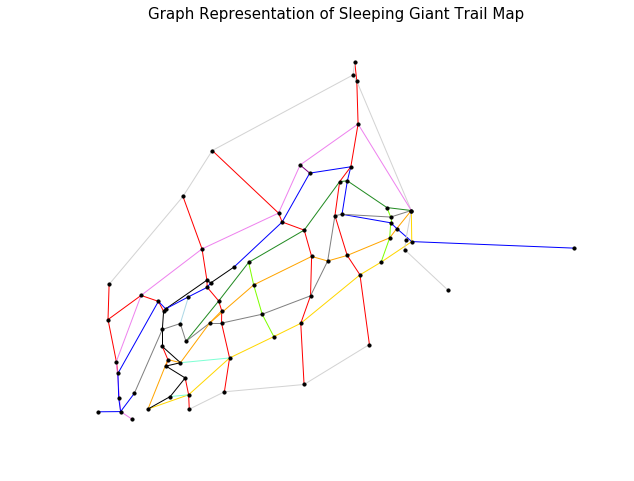

In [83]:
plt.figure(figsize=(8, 6))
nx.draw(g, pos=node_positions, edge_color=edge_colors, node_size=10, node_color='black')
plt.title('Graph Representation of Sleeping Giant Trail Map', size=15)
plt.show()

# Overview of CPP Algorithm

Solving the Chinese Postman Problem is quite simple conceptually:

Find all nodes with odd degree (very easy).
(Find all trail intersections where the number of trails touching that intersection is an odd number) 

Add edges to the graph such that all nodes of odd degree are made even. These added edges must be duplicates from the original graph (we’ll assume no bushwhacking for this problem). The set of edges added should sum to the minimum distance possible (hard…np-hard to be precise).
(In simpler terms, minimize the amount of double backing on a route that hits every trail) 

Given a starting point, find the Eulerian tour over the augmented dataset (moderately easy).
(Once we know which trails we’ll be double backing on, actually calculate the route from beginning to end)

# Assumptions and Simplifications

Assumption 1: Required trails only
As you can see from the trail map above, there are roads along the borders of the park that could be used to connect trails, particularly the red trails. There are also some trails (Horseshoe and unmarked blazes) which are not required per the Giantmaster log, but could be helpful to prevent lengthy double backing. The inclusion of optional trails is actually an established variant of the CPP called the Rural Postman Problem. We ignore optional trails in this tutorial and focus on required trails only.

Assumption 2: Uphill == downhill
The CPP assumes that the cost of walking a trail is equivalent to its distance, regardless of which direction it is walked. However, some of these trails are rather hilly and will require more energy to walk up than down. Some metric that combines both distance and elevation change over a directed graph could be incorporated into an extension of the CPP called the Windy Postman Problem.

Assumption 3: No parallel edges (trails)

While possible, the inclusion of parallel edges (multiple trails connecting the same two nodes) adds complexity to computation. Luckily this only occurs twice here (Blue <=> Red Diamond and Blue <=> Tower Trail). This is addressed by a bit of a hack to the edge list: duplicate nodes are included with a _dupe suffix to capture every trail while maintaining uniqueness in the edges. The CPP implementation in the postman_problems package I wrote robustly handles parallel edges in a more elegant way if you’d like to solve the CPP on your own graph with many parallel edges.

# CPP Step 1: Find Nodes of Odd Degree

In [84]:
# Calculate list of nodes with odd degree
# nodes_odd_degree = [v for v, d in g.degree_iter() if d % 2 == 1]  # deprecated after NX 1.11
nodes_odd_degree = [v for v, d in g.degree() if d % 2 == 1]
        
# Preview
nodes_odd_degree[0:5]

['rc_end_north', 'rc_end_south', 'rt_end_north', 'o_rt', 'y_rt']

In [85]:
# Counts
print('Number of nodes of odd degree: {}'.format(len(nodes_odd_degree)))
print('Number of total nodes: {}'.format(len(g.nodes())))

Number of nodes of odd degree: 34
Number of total nodes: 78


# CPP Step 2: Find Min Distance Pairs

This is really the meat of the problem. You’ll break it down into 5 parts:

Compute all possible pairs of odd degree nodes.
Compute the shortest path between each node pair calculated in 1.
Create a complete graph connecting every node pair in 1. with shortest path distance attributes calculated in 2.
Compute a minimum weight matching of the graph calculated in 3. 
(This boils down to determining how to pair the odd nodes such that the sum of the distance between the pairs is as small as possible).
Augment the original graph with the shortest paths between the node pairs calculated in 4.

## Step 2.1: Compute Node Pairs

You use the itertools combination function to compute all possible pairs of the odd degree nodes. Your graph is undirected, so we don’t care about order: For example, (a,b) == (b,a).

In [86]:
# Compute all pairs of odd nodes. in a list of tuples
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))

# Preview pairs of odd degree nodes
odd_node_pairs[0:10]

[('rc_end_north', 'rc_end_south'),
 ('rc_end_north', 'rt_end_north'),
 ('rc_end_north', 'o_rt'),
 ('rc_end_north', 'y_rt'),
 ('rc_end_north', 'rt_end_south'),
 ('rc_end_north', 'rh_end_north'),
 ('rc_end_north', 'rh_end_tt_1'),
 ('rc_end_north', 'rh_end_tt_2'),
 ('rc_end_north', 'rh_end_tt_3'),
 ('rc_end_north', 'rh_end_tt_4')]

In [87]:
# Counts
print('Number of pairs: {}'.format(len(odd_node_pairs)))

Number of pairs: 561


Let’s confirm that this number of pairs is correct with a the combinatoric below. Luckily, you only have 630 pairs to worry about. Your computation time to solve this CPP example is trivial (a couple seconds).

However, if you had 3,600 odd node pairs instead, you’d have ~6.5 million pairs to optimize. That’s a ~10,000x increase in output given a 100x increase in input size.

#ofpairs=nchooser=(nr)=n!r!(n−r)!=36!2!(36−2)!=630

## Step 2.2: Compute Shortest Paths between Node Pairs

This is the first step that involves some real computation. Luckily networkx has a convenient implementation of Dijkstra’s algorithm to compute the shortest path between two nodes. You apply this function to every pair (all 630) calculated above in odd_node_pairs.

In [88]:
def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

In [89]:
# Compute shortest paths.  Return a dictionary with node pairs keys and a single value equal to shortest path distance.
odd_node_pairs_shortest_paths = get_shortest_paths_distances(g, odd_node_pairs, 'distance')

# Preview with a bit of hack (there is no head/slice method for dictionaries).
dict(list(odd_node_pairs_shortest_paths.items())[0:10])

{('rc_end_north', 'rc_end_south'): 1.75,
 ('rc_end_north', 'rt_end_north'): 0.28,
 ('rc_end_north', 'o_rt'): 0.9200000000000002,
 ('rc_end_north', 'y_rt'): 1.1700000000000002,
 ('rc_end_north', 'rt_end_south'): 1.35,
 ('rc_end_north', 'rh_end_north'): 1.05,
 ('rc_end_north', 'rh_end_tt_1'): 1.1300000000000001,
 ('rc_end_north', 'rh_end_tt_2'): 1.2700000000000002,
 ('rc_end_north', 'rh_end_tt_3'): 1.3800000000000003,
 ('rc_end_north', 'rh_end_tt_4'): 1.5300000000000002}

## Step 2.3: Create Complete Graph

A complete graph is simply a graph where every node is connected to every other node by a unique edge.

The graph you create below has 36 nodes and 630 edges with their corresponding edge weight (distance).

create_complete_graph is defined to calculate it. The flip_weights parameter is used to transform the distance to the weight attribute where smaller numbers reflect large distances and high numbers reflect short distances. This sounds a little counter intuitive, but is necessary for Step 2.4 where you calculate the minimum weight matching on the complete graph.

Ideally you’d calculate the minimum weight matching directly, but NetworkX only implements a max_weight_matching function which maximizes, rather than minimizes edge weight. We hack this a bit by negating (multiplying by -1) the distance attribute to get weight. This ensures that order and scale by distance are preserved, but reversed.

In [90]:
def create_complete_graph(pair_weights, flip_weights=True):
    """
    Create a completely connected graph using a list of vertex pairs and the shortest path distances between them
    Parameters: 
        pair_weights: list[tuple] from the output of get_shortest_paths_distances
        flip_weights: Boolean. Should we negate the edge attribute in pair_weights?
    """
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = - v if flip_weights else v
        # g.add_edge(k[0], k[1], {'distance': v, 'weight': wt_i})  # deprecated after NX 1.11 
        g.add_edge(k[0], k[1], **{'distance': v, 'weight': wt_i})  
    return g

In [91]:
# Generate the complete graph
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

# Counts
print('Number of nodes: {}'.format(len(g_odd_complete.nodes())))
print('Number of edges: {}'.format(len(g_odd_complete.edges())))

Number of nodes: 34
Number of edges: 561


For a visual prop, the fully connected graph of odd degree node pairs is plotted below. Note that you preserve the X, Y coordinates of each node, but the edges do not necessarily represent actual trails. For example, two nodes could be connected by a single edge in this graph, but the shortest path between them could be 5 hops through even degree nodes (not shown here).

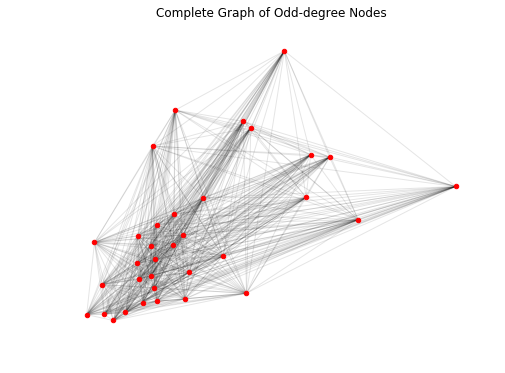

In [92]:
# Plot the complete graph of odd-degree nodes
plt.figure(figsize=(8, 6))
pos_random = nx.random_layout(g_odd_complete)
nx.draw_networkx_nodes(g_odd_complete, node_positions, node_size=20, node_color="red")
nx.draw_networkx_edges(g_odd_complete, node_positions, alpha=0.1)
plt.axis('off')
plt.title('Complete Graph of Odd-degree Nodes')
plt.show()

# Step 2.4: Compute Minimum Weight Matching

This is the most complex step in the CPP. You need to find the odd degree node pairs whose combined sum (of distance between them) is as small as possible. So for your problem, this boils down to selecting the optimal 18 edges (36 odd degree nodes / 2) from the hairball of a graph generated in 2.3.

This Maximum Weight Matching has since been folded into and maintained within the NetworkX package.

In [93]:
# Compute min weight matching.
# Note: max_weight_matching uses the 'weight' attribute by default as the attribute to maximize.
odd_matching_dupes = nx.algorithms.max_weight_matching(g_odd_complete, True)

print('Number of edges in matching: {}'.format(len(odd_matching_dupes)))

Number of edges in matching: 34


The matching output (odd_matching_dupes) is a dictionary. Although there are 36 edges in this matching, you only want 18. Each edge-pair occurs twice (once with node 1 as the key and a second time with node 2 as the key of the dictionary).

In [94]:
# Preview of matching with dupes
odd_matching_dupes

{'v_bv': 'b_bv',
 'b_bv': 'v_bv',
 'rh_end_tt_4': 'y_rh',
 'y_rh': 'rh_end_tt_4',
 'g_w': 'w_bw',
 'w_bw': 'g_w',
 'rh_end_tt_3': 'rh_end_tt_2',
 'o_tt': 'o_w_1',
 'o_rt': 'g_gy1',
 'o_w_1': 'o_tt',
 'b_v': 'b_end_west',
 'v_end_west': 'b_rd',
 'rh_end_tt_1': 'rh_end_north',
 'rh_end_tt_2': 'rh_end_tt_3',
 'o_y_tt_end_west': 'nature_end_west',
 'nature_end_west': 'o_y_tt_end_west',
 'b_bw': 'b_tt_2',
 'b_tt_2': 'b_bw',
 'y_rt': 'y_gy1',
 'rt_end_south': 'rc_end_south',
 'g_gy2': 'hs_end_east',
 'y_gy2': 'b_end_east',
 'rc_end_north': 'rt_end_north',
 'rt_end_north': 'rc_end_north',
 'b_rd': 'v_end_west',
 'rh_end_north': 'rh_end_tt_1',
 'g_gy1': 'o_rt',
 'y_gy1': 'y_rt',
 'v_end_east': 'hs_hs',
 'hs_hs': 'v_end_east',
 'rc_end_south': 'rt_end_south',
 'b_end_west': 'b_v',
 'hs_end_east': 'g_gy2',
 'b_end_east': 'y_gy2'}

You convert this dictionary to a list of tuples since you have an undirected graph and order does not matter. Removing duplicates yields the unique 18 edge-pairs that cumulatively sum to the least possible distance.b

In [95]:
# Convert matching to list of deduped tuples
odd_matching = list(pd.unique([tuple(sorted([k, v])) for k, v in odd_matching_dupes.items()]))

# Counts
print('Number of edges in matching (deduped): {}'.format(len(odd_matching)))

Number of edges in matching (deduped): 17


In [96]:
# Preview of deduped matching
odd_matching

[('b_bv', 'v_bv'),
 ('rh_end_tt_4', 'y_rh'),
 ('g_w', 'w_bw'),
 ('rh_end_tt_2', 'rh_end_tt_3'),
 ('o_tt', 'o_w_1'),
 ('g_gy1', 'o_rt'),
 ('b_end_west', 'b_v'),
 ('b_rd', 'v_end_west'),
 ('rh_end_north', 'rh_end_tt_1'),
 ('nature_end_west', 'o_y_tt_end_west'),
 ('b_bw', 'b_tt_2'),
 ('y_gy1', 'y_rt'),
 ('rc_end_south', 'rt_end_south'),
 ('g_gy2', 'hs_end_east'),
 ('b_end_east', 'y_gy2'),
 ('rc_end_north', 'rt_end_north'),
 ('hs_hs', 'v_end_east')]

Let’s visualize these pairs on the complete graph plotted earlier in step 2.3. As before, while the node positions reflect the true graph (trail map) here, the edge distances shown (blue lines) are as the crow flies. The actual shortest route from one node to another could involve multiple edges that twist and turn with considerably longer distance.

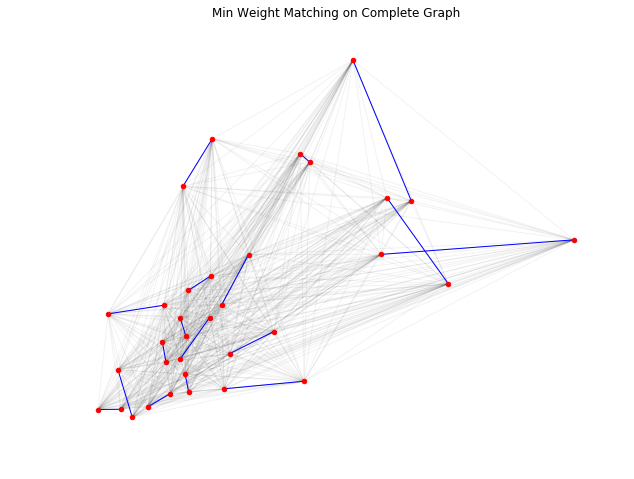

In [97]:
plt.figure(figsize=(8, 6))

# Plot the complete graph of odd-degree nodes
nx.draw(g_odd_complete, pos=node_positions, node_size=20, alpha=0.05)

# Create a new graph to overlay on g_odd_complete with just the edges from the min weight matching
g_odd_complete_min_edges = nx.Graph(odd_matching)
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, edge_color='blue', node_color='red')

plt.title('Min Weight Matching on Complete Graph')
plt.show()

To illustrate how this fits in with the original graph, you plot the same min weight pairs (blue lines), but over the trail map (faded) instead of the complete graph. Again, note that the blue lines are the bushwhacking route (as the crow flies edges, not actual trails). You still have a little bit of work to do to find the edges that comprise the shortest route between each pair in Step 3.

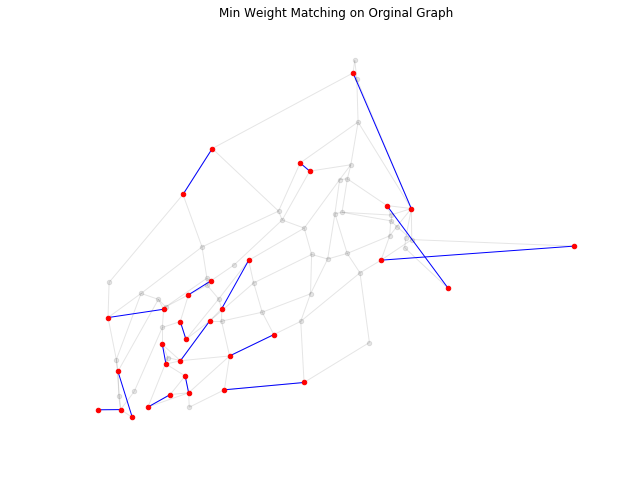

In [98]:
plt.figure(figsize=(8, 6))

# Plot the original trail map graph
nx.draw(g, pos=node_positions, node_size=20, alpha=0.1, node_color='black')

# Plot graph to overlay with just the edges from the min weight matching
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, alpha=1, node_color='red', edge_color='blue')

plt.title('Min Weight Matching on Orginal Graph')
plt.show()

## Step 2.5: Augment the Original Graph

Now you augment the original graph with the edges from the matching calculated in 2.4. A simple function to do this is defined below which also notes that these new edges came from the augmented graph. You’ll need to know this in ** 3.** when you actually create the Eulerian circuit through the graph.

In [99]:
def add_augmenting_path_to_graph(graph, min_weight_pairs):
    """
    Add the min weight matching edges to the original graph
    Parameters:
        graph: NetworkX graph (original graph from trailmap)
        min_weight_pairs: list[tuples] of node pairs from min weight matching
    Returns:
        augmented NetworkX graph
    """
    
    # We need to make the augmented graph a MultiGraph so we can add parallel edges
    graph_aug = nx.MultiGraph(graph.copy())
    for pair in min_weight_pairs:
        graph_aug.add_edge(pair[0], 
                           pair[1], 
                           **{'distance': nx.dijkstra_path_length(graph, pair[0], pair[1]), 'trail': 'augmented'}
                           # attr_dict={'distance': nx.dijkstra_path_length(graph, pair[0], pair[1]),
                           #            'trail': 'augmented'}  # deprecated after 1.11
                          )
    return graph_aug

In [100]:
# Create augmented graph: add the min weight matching edges to g
g_aug = add_augmenting_path_to_graph(g, odd_matching)

# Counts
print('Number of edges in original graph: {}'.format(len(g.edges())))
print('Number of edges in augmented graph: {}'.format(len(g_aug.edges())))

Number of edges in original graph: 131
Number of edges in augmented graph: 148


Let’s also confirm that every node now has even degree:

In [101]:
# pd.value_counts(g_aug.degree())  # deprecated after NX 1.11
pd.value_counts([e[1] for e in g_aug.degree()])

4    58
2    14
6     6
dtype: int64

# CPP Step 3: Compute Eulerian Circuit

Now that you have a graph with even degree the hard optimization work is over.

Limitations you will fix:

The augmented graph could (and likely will) contain edges that didn’t exist on the original graph. To get the circuit (without bushwhacking), you must break down these augmented edges into the shortest path through the edges that actually exist.

eulerian_circuit only returns the order in which we hit each node. It does not return the attributes of the edges needed to complete the circuit. This is necessary because you need to keep track of which edges have been walked already when multiple edges exist between two nodes.

Limitations you won’t fix:

To save your legs some work, you could relax the assumption of the Eulerian circuit that one start and finish at the same node. An [Eulerian path] (the general case of the Eulerian circuit), can also be found if there are exactly two nodes of odd degree. This would save you a little bit of double backing...presuming you could get a ride back from the other end of the park. However, at the time of this writing, NetworkX does not provide a Euler Path algorithm. The [eulerian_circuit code] isn't too bad and could be adopted for this case, but you'll keep it simple here.

# Naive Circuit

Nonetheless, let’s start with the simple yet incomplete solution:

In [102]:
naive_euler_circuit = list(nx.eulerian_circuit(g_aug, source='b_end_east'))

As expected, the length of the naive Eulerian circuit is equal to the number of the edges in the augmented graph.

In [103]:
print('Length of eulerian circuit: {}'.format(len(naive_euler_circuit)))

Length of eulerian circuit: 148


The output is just a list of tuples which represent node pairs. Note that the first node of each pair is the same as the second node from the preceding pair.

In [104]:
# Preview naive Euler circuit
naive_euler_circuit[0:10]

[('b_end_east', 'y_gy2'),
 ('y_gy2', 'o_gy2'),
 ('o_gy2', 'b_gy2'),
 ('b_gy2', 'w_gy2'),
 ('w_gy2', 'g_gy2'),
 ('g_gy2', 'hs_end_east'),
 ('hs_end_east', 'hs_y'),
 ('hs_y', 'b_hs'),
 ('b_hs', 'park_east'),
 ('park_east', 'g_gy2')]

# Correct Circuit

Now let’s define a function that utilizes the original graph to tell you which trails to use to get from node A to node B. Although verbose in code, this logic is actually quite simple. You simply transform the naive circuit which included edges that did not exist in the original graph to a Eulerian circuit using only edges that exist in the original graph.

You loop through each edge in the naive Eulerian circuit (naive_euler_circuit). Wherever you encounter an edge that does not exist in the original graph, you replace it with the sequence of edges comprising the shortest path between its nodes using the original graph.

In [105]:
def create_eulerian_circuit(graph_augmented, graph_original, starting_node=None):
    """Create the eulerian path using only edges from the original graph."""
    euler_circuit = []
    naive_circuit = list(nx.eulerian_circuit(graph_augmented, source=starting_node))
    
    for edge in naive_circuit:
        edge_data = graph_augmented.get_edge_data(edge[0], edge[1])    
        
        if edge_data[0]['trail'] != 'augmented':
            # If `edge` exists in original graph, grab the edge attributes and add to eulerian circuit.
            edge_att = graph_original[edge[0]][edge[1]]
            euler_circuit.append((edge[0], edge[1], edge_att)) 
        else: 
            aug_path = nx.shortest_path(graph_original, edge[0], edge[1], weight='distance')
            aug_path_pairs = list(zip(aug_path[:-1], aug_path[1:]))
            
            print('Filling in edges for augmented edge: {}'.format(edge))
            print('Augmenting path: {}'.format(' => '.join(aug_path)))
            print('Augmenting path pairs: {}\n'.format(aug_path_pairs))
            
            # If `edge` does not exist in original graph, find the shortest path between its nodes and 
            #  add the edge attributes for each link in the shortest path.
            for edge_aug in aug_path_pairs:
                edge_aug_att = graph_original[edge_aug[0]][edge_aug[1]]
                euler_circuit.append((edge_aug[0], edge_aug[1], edge_aug_att))
                                      
    return euler_circuit

You hack limitation 3 a bit by starting the Eulerian circuit at the far east end of the park on the Blue trail (node “b_end_east”). When actually running this thing, you could simply skip the last direction which doubles back on it.

Verbose print statements are added to convey what happens when you replace nonexistent edges from the augmented graph with the shortest path using edges that actually exist.

In [106]:
# Create the Eulerian circuit
euler_circuit = create_eulerian_circuit(g_aug, g, 'b_end_east')

Filling in edges for augmented edge: ('b_end_east', 'y_gy2')
Augmenting path: b_end_east => b_y => b_o => o_gy2 => y_gy2
Augmenting path pairs: [('b_end_east', 'b_y'), ('b_y', 'b_o'), ('b_o', 'o_gy2'), ('o_gy2', 'y_gy2')]

Filling in edges for augmented edge: ('g_gy2', 'hs_end_east')
Augmenting path: g_gy2 => park_east => b_hs => hs_y => hs_end_east
Augmenting path pairs: [('g_gy2', 'park_east'), ('park_east', 'b_hs'), ('b_hs', 'hs_y'), ('hs_y', 'hs_end_east')]

Filling in edges for augmented edge: ('g_gy1', 'o_rt')
Augmenting path: g_gy1 => g_rt => o_rt
Augmenting path pairs: [('g_gy1', 'g_rt'), ('g_rt', 'o_rt')]

Filling in edges for augmented edge: ('rh_end_tt_2', 'rh_end_tt_3')
Augmenting path: rh_end_tt_2 => o_rh => rh_end_tt_3
Augmenting path pairs: [('rh_end_tt_2', 'o_rh'), ('o_rh', 'rh_end_tt_3')]

Filling in edges for augmented edge: ('b_bw', 'b_tt_2')
Augmenting path: b_bw => b_rt => b_tt_2
Augmenting path pairs: [('b_bw', 'b_rt'), ('b_rt', 'b_tt_2')]

Filling in edges for au

You see that the length of the Eulerian circuit is longer than the naive circuit, which makes sense.

In [107]:
print('Length of Eulerian circuit: {}'.format(len(euler_circuit)))

Length of Eulerian circuit: 163


# CPP Solution

Here’s a printout of the solution in text:

In [108]:
# Preview first 20 directions of CPP solution
for i, edge in enumerate(euler_circuit[0:20]):
    print(i, edge)

0 ('b_end_east', 'b_y', {'trail': 'b', 'color': 'blue', 'distance': 1.32, 'estimate': 0, 'required': 1})
1 ('b_y', 'b_o', {'trail': 'b', 'color': 'blue', 'distance': 0.08, 'estimate': 0, 'required': 1})
2 ('b_o', 'o_gy2', {'trail': 'o', 'color': 'orange', 'distance': 0.06, 'estimate': 0, 'required': 1})
3 ('o_gy2', 'y_gy2', {'trail': 'gy2', 'color': 'chartreuse', 'distance': 0.12, 'estimate': 0, 'required': 1})
4 ('y_gy2', 'o_gy2', {'trail': 'gy2', 'color': 'chartreuse', 'distance': 0.12, 'estimate': 0, 'required': 1})
5 ('o_gy2', 'b_gy2', {'trail': 'gy2', 'color': 'chartreuse', 'distance': 0.07, 'estimate': 0, 'required': 1})
6 ('b_gy2', 'w_gy2', {'trail': 'gy2', 'color': 'chartreuse', 'distance': 0.03, 'estimate': 1, 'required': 1})
7 ('w_gy2', 'g_gy2', {'trail': 'gy2', 'color': 'chartreuse', 'distance': 0.05, 'estimate': 0, 'required': 1})
8 ('g_gy2', 'park_east', {'trail': 'g', 'color': 'forestgreen', 'distance': 0.14, 'estimate': 0, 'required': 1})
9 ('park_east', 'b_hs', {'trail'

You can tell pretty quickly that the algorithm is not very loyal to any particular trail, jumping from one to the next pretty quickly. An extension of this approach could get fancy and build in some notion of trail loyalty into the objective function to make actually running this route more manageable.b

# Stats

Let’s peak into your solution to see how reasonable it looks.

In [109]:
# Computing some stats
total_mileage_of_circuit = sum([edge[2]['distance'] for edge in euler_circuit])
total_mileage_on_orig_trail_map = sum(nx.get_edge_attributes(g, 'distance').values())
_vcn = pd.value_counts(pd.value_counts([(e[0]) for e in euler_circuit]), sort=False)
node_visits = pd.DataFrame({'n_visits': _vcn.index, 'n_nodes': _vcn.values})
_vce = pd.value_counts(pd.value_counts([sorted(e)[0] + sorted(e)[1] for e in nx.MultiDiGraph(euler_circuit).edges()]))
edge_visits = pd.DataFrame({'n_visits': _vce.index, 'n_edges': _vce.values})

# Printing stats
print('Mileage of circuit: {0:.2f}'.format(total_mileage_of_circuit))
print('Mileage on original trail map: {0:.2f}'.format(total_mileage_on_orig_trail_map))
print('Mileage retracing edges: {0:.2f}'.format(total_mileage_of_circuit-total_mileage_on_orig_trail_map))
print('Percent of mileage retraced: {0:.2f}%\n'.format((1-total_mileage_of_circuit/total_mileage_on_orig_trail_map)*-100))

print('Number of edges in circuit: {}'.format(len(euler_circuit)))
print('Number of edges in original graph: {}'.format(len(g.edges())))
print('Number of nodes in original graph: {}\n'.format(len(g.nodes())))

print('Number of edges traversed more than once: {}\n'.format(len(euler_circuit)-len(g.edges())))  

print('Number of times visiting each node:')
print(node_visits.to_string(index=False))

print('\nNumber of times visiting each edge:')
print(edge_visits.to_string(index=False))

Mileage of circuit: 36.71
Mileage on original trail map: 30.20
Mileage retracing edges: 6.51
Percent of mileage retraced: 21.56%

Number of edges in circuit: 163
Number of edges in original graph: 131
Number of nodes in original graph: 78

Number of edges traversed more than once: 32

Number of times visiting each node:
n_visits  n_nodes
       1       11
       2       51
       3       14
       4        2

Number of times visiting each edge:
n_visits  n_edges
       1       99
       2       32


# Visualize CPP Solution

That said, the built-in NetworkX drawing functionality with matplotlib is powerful enough for eyeballing and visually exploring basic graphs, so you stick with NetworkX draw for this tutorial.

## Create CPP Graph

Your first step is to convert the list of edges to walk in the Euler circuit into an edge list with plot-friendly attributes.

create_cpp_edgelist Creates an edge list with some additional attributes that you’ll use for plotting:

sequence: records a sequence of when we walk each edge.
visits: is simply the number of times we walk a particular edge.

In [110]:
def create_cpp_edgelist(euler_circuit):
    """
    Create the edgelist without parallel edge for the visualization
    Combine duplicate edges and keep track of their sequence and # of walks
    Parameters:
        euler_circuit: list[tuple] from create_eulerian_circuit
    """
    cpp_edgelist = {}

    for i, e in enumerate(euler_circuit):
        edge = frozenset([e[0], e[1]])

        if edge in cpp_edgelist:
            cpp_edgelist[edge][2]['sequence'] += ', ' + str(i)
            cpp_edgelist[edge][2]['visits'] += 1

        else:
            cpp_edgelist[edge] = e
            cpp_edgelist[edge][2]['sequence'] = str(i)
            cpp_edgelist[edge][2]['visits'] = 1
        
    return list(cpp_edgelist.values())

Let’s create the CPP edge list:

In [111]:
cpp_edgelist = create_cpp_edgelist(euler_circuit)

As expected, your edge list has the same number of edges as the original graph.

In [112]:
print('Number of edges in CPP edge list: {}'.format(len(cpp_edgelist)))

Number of edges in CPP edge list: 131


The CPP edge list looks similar to euler_circuit, just with a few additional attributes.

In [113]:
# Preview CPP plot-friendly edge list
cpp_edgelist[0:3]

[('b_end_east',
  'b_y',
  {'trail': 'b',
   'color': 'blue',
   'distance': 1.32,
   'estimate': 0,
   'required': 1,
   'sequence': '0, 162',
   'visits': 2}),
 ('b_y',
  'b_o',
  {'trail': 'b',
   'color': 'blue',
   'distance': 0.08,
   'estimate': 0,
   'required': 1,
   'sequence': '1, 161',
   'visits': 2}),
 ('b_o',
  'o_gy2',
  {'trail': 'o',
   'color': 'orange',
   'distance': 0.06,
   'estimate': 0,
   'required': 1,
   'sequence': '2, 148',
   'visits': 2})]

Now let’s make the graph:

In [114]:
# Create CPP solution graph
g_cpp = nx.Graph(cpp_edgelist)

# Visualization 1: Retracing Steps

Here you illustrate which edges are walked once (gray) and more than once (blue). This is the "correct" version of the visualization created in 2.4 which showed the naive (as the crow flies) connections between the odd node pairs (red). That is corrected here by tracing the shortest path through edges that actually exist for each pair of odd degree nodes.

If the optimization is any good, these blue lines should represent the least distance possible. Specifically, the minimum distance needed to generate a matching of the odd degree nodes.

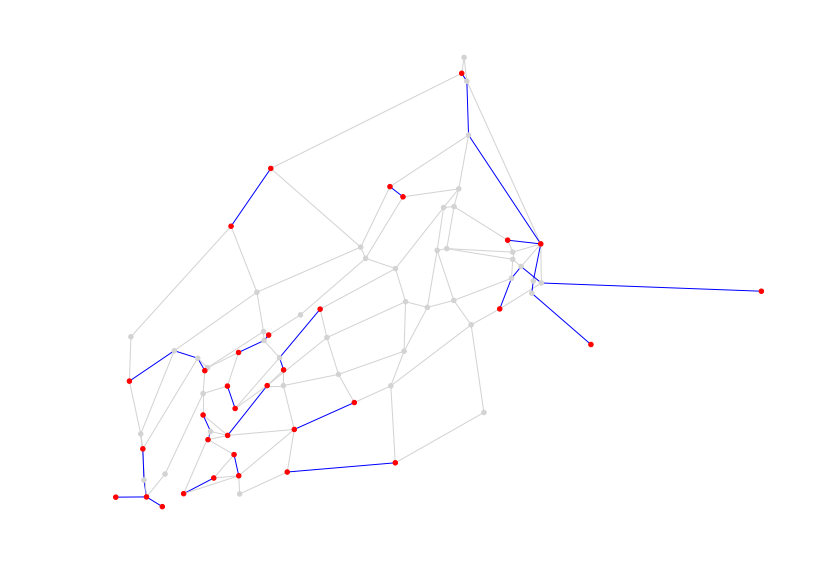

In [115]:
plt.figure(figsize=(14, 10))

visit_colors = {1:'lightgray', 2:'blue'}
edge_colors = [visit_colors[e[2]['visits']] for e in g_cpp.edges(data=True)]
node_colors = ['red'  if node in nodes_odd_degree else 'lightgray' for node in g_cpp.nodes()]

nx.draw_networkx(g_cpp, pos=node_positions, node_size=20, node_color=node_colors, edge_color=edge_colors, with_labels=False)
plt.axis('off')
plt.show()

# Visualization 2: CPP Solution Sequence

Here you plot the original graph (trail map) annotated with the sequence numbers in which we walk the trails per the CPP solution. Multiple numbers indicate trails we must double back on.

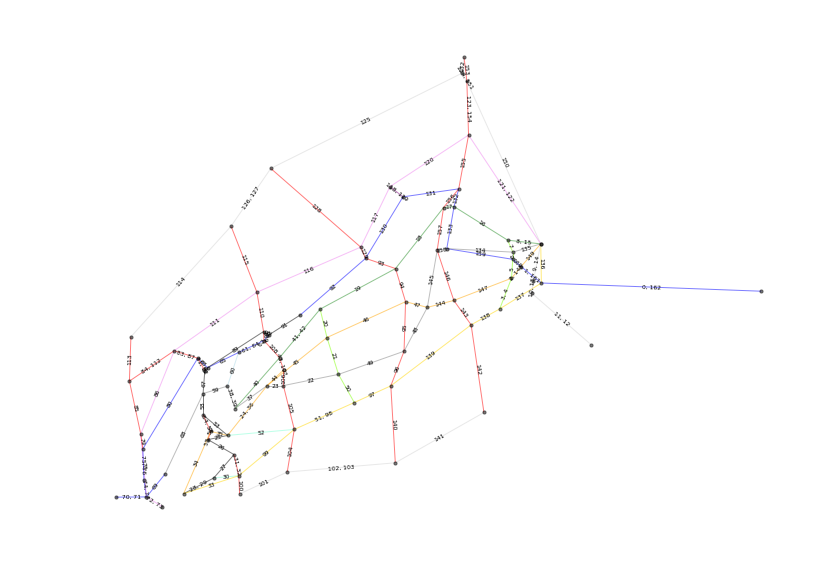

In [116]:
plt.figure(figsize=(14, 10))

edge_colors = [e[2]['color'] for e in g_cpp.edges(data=True)]
nx.draw_networkx(g_cpp, pos=node_positions, node_size=10, node_color='black', edge_color=edge_colors, with_labels=False, alpha=0.5)

bbox = {'ec':[1,1,1,0], 'fc':[1,1,1,0]}  # hack to label edges over line (rather than breaking up line)
edge_labels = nx.get_edge_attributes(g_cpp, 'sequence')
nx.draw_networkx_edge_labels(g_cpp, pos=node_positions, edge_labels=edge_labels, bbox=bbox, font_size=6)

plt.axis('off')
plt.show()

# Visualization 3: Movie

The movie below that traces the Euler circuit from beginning to end is embedded below. Edges are colored black the first time they are walked and red the second time.

Note that this gif doesn’t do give full visual justice to edges which overlap another or are too small to visualize properly. A more robust visualization library such as graphviz could address this by plotting splines instead of straight lines between nodes.

The code that creates it is presented below as a reference.

First a PNG image is produced for each direction (edge walked) from the CPP solution.

In [119]:
visit_colors = {1:'black', 2:'red'}
edge_cnter = {}
g_i_edge_colors = []
for i, e in enumerate(euler_circuit, start=1):

    edge = frozenset([e[0], e[1]])
    if edge in edge_cnter:
        edge_cnter[edge] += 1
    else:
        edge_cnter[edge] = 1

    # Full graph (faded in background)
    nx.draw_networkx(g_cpp, pos=node_positions, node_size=6, node_color='gray', with_labels=False, alpha=0.07)

    # Edges walked as of iteration i
    euler_circuit_i = copy.deepcopy(euler_circuit[0:i])
    for i in range(len(euler_circuit_i)):
        edge_i = frozenset([euler_circuit_i[i][0], euler_circuit_i[i][1]])
        euler_circuit_i[i][2]['visits_i'] = edge_cnter[edge_i]
    g_i = nx.Graph(euler_circuit_i)
    g_i_edge_colors = [visit_colors[e[2]['visits_i']] for e in g_i.edges(data=True)]

    nx.draw_networkx_nodes(g_i, pos=node_positions, node_size=6, alpha=0.6, node_color='lightgray', with_labels=False, linewidths=0.1)
    nx.draw_networkx_edges(g_i, pos=node_positions, edge_color=g_i_edge_colors, alpha=0.8)

    plt.axis('off')
    plt.savefig('./fig/png/img{}.png'.format(i), dpi=120, bbox_inches='tight')
    plt.close()

Then the the PNG images are stitched together to make the nice little gif above.

First the PNGs are sorted in the order from 0 to 157. Then they are stitched together using imageio at 3 frames per second to create the gif.

In [120]:
import glob
import numpy as np
import imageio
import os

def make_circuit_video(image_path, movie_filename, fps=5):
    # sorting filenames in order
    filenames = glob.glob(image_path + 'img*.png')
    filenames_sort_indices = np.argsort([int(os.path.basename(filename).split('.')[0][3:]) for filename in filenames])
    filenames = [filenames[i] for i in filenames_sort_indices]

    # make movie
    with imageio.get_writer(movie_filename, mode='I', fps=fps) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

make_circuit_video('./fig/png/', './fig/gif/cpp_route_animation.gif', fps=3)